# Video Preprocessing

Description

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json

In [3]:
from video_analyzer import VideoAnalyzer
from preprocessor import Preprocessor

2025-03-31 18:11:58.703556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743412318.727486   30846 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743412318.734834   30846 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 18:11:58.767131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
timestamp = "28032025"
path_to_root = "/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/"

In [5]:
metadata = pd.read_csv(os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "target_dataset_video_metadata.csv"
    ))

In [ ]:
i = 1
metadata_row = metadata.iloc[i].copy()
metadata_row

filename        ajudar_sb_2.mp4
label                    ajudar
data_source                  sb
frame_count                  79
fps                    29.97003
duration_sec                  2
width                      1280
height                      720
Name: 1, dtype: object

## Initialize VideoAnalyzer

In [7]:
params = {}
params["motion_start_threshold"] = 0.2
# params["verbose"] =False
params["reuse_results"] = True

In [8]:
metadata_row.loc['motion_end_threshold'] = 0.3

In [9]:
analyzer = VideoAnalyzer(
    metadata_row,
    timestamp,
    path_to_root,
    params,
    # verbose=False
)

Using parameters from metadata:
	motion_end_threshold = 0.3
Using parameters from params dict:
	motion_start_threshold = 0.2
	reuse_results = True
Using parameters from default values:
	motion_avg_weights = {'basic': 0.3, 'bg_sub': 0.7}
	moving_avg_window_duration = 0.2
	motion_threshold_method = simple
	pose_static_image_mode = False
	pose_model_complexity = 1
	pose_smooth_landmarks = True
	pose_min_detection_confidence = 0.5
	pose_min_tracking_confidence = 0.5
Initialized VideoAnalyzer for ajudar_ne_1.mp4
Video properties: 12.0 fps, 240x176, 3.00 seconds


## Motion Detection

In [10]:
analyzer.motion_data

{}

In [11]:
motion_data = analyzer.motion_detect()

Loaded motion detection results from versionA
window_duration: 0.2 seconds, at 12.0 fps = 2 frame window_size


In [12]:
motion_data.keys()

dict_keys(['basic_raw', 'bg_sub_raw', 'basic_normalized', 'bg_sub_normalized', 'weighted_avg', 'smoothed'])

In [13]:
motion_result = analyzer.motion_analyze()

Analyzing motion using simple method with thresholds 0.2/0.3
Motion detected from frame 6 to 35 (2.42 seconds)


In [14]:
motion_result

{'start_frame': 6,
 'end_frame': 35,
 'start_time': 0.5,
 'end_time': 2.9166666666666665,
 'duration_frames': 29,
 'duration_sec': 2.4166666666666665}

In [15]:
analyzer.motion_data.keys()

dict_keys(['basic_raw', 'bg_sub_raw', 'basic_normalized', 'bg_sub_normalized', 'weighted_avg', 'smoothed', 'analysis'])

## Pose Estimation

In [16]:
analyzer.pose_estimation_dir

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks'

In [14]:
pose_data = analyzer.pose_detect()

Loaded pose estimation results from versionA


In [18]:
analyzer.pose_data.keys()

dict_keys(['params', 'landmarks_raw'])

In [17]:
pose_result = analyzer.pose_analyze()

Analyzing pose data...
Pose analysis complete
Horizontal offsets: {'shoulders': {'mean': 0.485783673484217, 'median': 0.48647886514663696, 'max': 0.5011348724365234, 'min': 0.4693884402513504}, 'face': {'mean': 0.4617192352359945, 'median': 0.4654083698987961, 'max': 0.4876764416694641, 'min': 0.43568241596221924}}
Vertical offsets: {'shoulders': {'mean': 0.5419730218974027, 'median': 0.541060134768486, 'max': 0.5612127780914307, 'min': 0.5202731192111969}, 'face': {'mean': 0.2606092748994177, 'median': 0.2586185485124588, 'max': 0.2975011467933655, 'min': 0.2298063486814499}}
Landmark measurements: {'shoulder_width': {'mean': 0.3144603380209611, 'median': 0.322241749436065, 'max': 0.33947361415925253}, 'hip_width': {'mean': 0.22059858718294068, 'median': 0.22124750378219374, 'max': 0.23112824713376973}, 'shoulder_to_hip': {'mean': 0.6164409528964432, 'median': 0.6150278579324255, 'max': 0.6438777743608111}, 'left_arm_length': {'mean': 0.41851797791257545, 'median': 0.35445257673761893

W0000 00:00:1743407261.836848   14866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743407261.854323   14866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743407261.856103   14864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743407261.856103   14871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743407261.857908   14866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743407261.868625   14869 inference_feedback_manager.cc:114] Feedback manager 

## Save Analysis Info

In [19]:
analysis_info = analyzer.save_analysis_info()

Saved analysis info to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Analysis/28032025/individual_json/ajudar_ne_1_analysis_info.json


In [20]:
analysis_info.keys()


dict_keys(['metadata', 'params', 'motion_analysis', 'pose_analysis'])

## Make Preprocessing Params

### Load analysis info

In [7]:
# load json as dict
with open(os.path.join(
    path_to_root, 
    "data", 
    "interim", 
    "Analysis", 
    timestamp, 
    "individual_json", 
    metadata_row["filename"].split(".")[0] + "_analysis_info.json"
    )) as f:
    analysis_info = json.load(f)

analysis_info.keys()

dict_keys(['metadata', 'params', 'motion_analysis', 'pose_analysis'])

### Get/Make Parameters for preprocessor
Preprocessor requires:
- start_frame 
- end_frame 
- horizontal_offset 
- x_scale_factor 
- y_scale_factor
- vertical_offset 
- target_duration

#### Start Frame / End Frame

In [8]:
start_frame = analysis_info["motion_analysis"]["start_frame"]
end_frame = analysis_info["motion_analysis"]["end_frame"]

#### Horizontal Offset

In [9]:
analysis_info["pose_analysis"]["horizontal_offsets"]

{'shoulders': {'mean': 0.4949150662633437,
  'median': 0.4965493381023407,
  'max': 0.5088723599910736,
  'min': 0.48143619298934937},
 'face': {'mean': 0.4935306469096413,
  'median': 0.49642214179039,
  'max': 0.5097975134849548,
  'min': 0.47643500566482544}}

In [10]:
shoulders_median = analysis_info["pose_analysis"]["horizontal_offsets"]["shoulders"]["median"]
face_median = analysis_info["pose_analysis"]["horizontal_offsets"]["face"]["median"]

shoulders_reference = 0.5
face_reference = 0.5

shoulders_offset = shoulders_reference - shoulders_median
face_offset = face_reference - face_median

shoulders_weight = 0.7
face_weight = 0.3
horizontal_offset = shoulders_weight * shoulders_offset + face_weight * face_offset
horizontal_offset

0.0034888207912445067

#### X Scale Factor, Y Scale Factor

In [11]:
analysis_info["pose_analysis"]["landmark_measurements"]

{'shoulder_width': {'mean': 0.19643654188049905,
  'median': 0.19426915924508475,
  'max': 0.2090008389332927},
 'hip_width': {'mean': 0.1257517734114194,
  'median': 0.12609480072645388,
  'max': 0.12865377607265074},
 'shoulder_to_hip': {'mean': 0.4793086848003729,
  'median': 0.47776501197933896,
  'max': 0.49827525282161705},
 'left_arm_length': {'mean': 0.24680996905222985,
  'median': 0.2298158988903358,
  'max': 0.3623422862255871},
 'right_arm_length': {'mean': 0.20022440832505897,
  'median': 0.18014849266203434,
  'max': 0.3336035031920863},
 'face_width': {'mean': 0.09077648767991894,
  'median': 0.08967295566002594,
  'max': 0.09869955922332911},
 'face_height': {'mean': 0.18541259318526834,
  'median': 0.1867652875494272,
  'max': 0.19387317661191944},
 'top_head_to_shoulders': {'mean': 0.2734140238807171,
  'median': 0.2845546454191208,
  'max': 0.3206898272037506},
 'nose_to_shoulders': {'mean': 0.19223914380314983,
  'median': 0.20292796194553375,
  'max': 0.25480055809

In [12]:
# Measurements from the video
## Horizontal
shoulder_width = analysis_info["pose_analysis"]["landmark_measurements"]["shoulder_width"]["mean"]
face_width = analysis_info["pose_analysis"]["landmark_measurements"]["face_width"]["mean"]
## Vertical
face_height = analysis_info["pose_analysis"]["landmark_measurements"]["face_height"]["mean"]
chin_to_shoulders = analysis_info["pose_analysis"]["landmark_measurements"]["chin_to_shoulders"]["median"]

# Reference values to scale to
## Horizontal
reference_shoulder_width = 0.3
reference_face_width = 0.15
## Vertical
reference_face_height = 0.2
reference_chin_to_shoulders = 0.15

# Scale Factors
## Horizontal
shoulder_width_weight = 0.7
face_width_weight = 0.3
x_scale_factor = shoulder_width_weight * reference_shoulder_width / shoulder_width + face_width_weight * reference_face_width / face_width
## Vertical
face_height_weight = 0.7
chin_to_shoulders_weight = 0.3
y_scale_factor = face_height_weight * reference_face_height / face_height + chin_to_shoulders_weight * reference_chin_to_shoulders / chin_to_shoulders

x_scale_factor, y_scale_factor

(1.5647706098056886, 1.2308604879523808)

In [13]:
# TODO: Plot the measured landmarks and the reference landmarks side by side

#### Vertical Offset

In [14]:
analysis_info["pose_analysis"]["vertical_offsets"]


{'shoulders': {'mean': 0.5217230369018603,
  'median': 0.5206832587718964,
  'max': 0.5372985899448395,
  'min': 0.5068168193101883},
 'face': {'mean': 0.32948389309871046,
  'median': 0.3191772401332855,
  'max': 0.38651880621910095,
  'min': 0.2788856029510498}}

In [15]:
# Measured
shoulders_median = analysis_info["pose_analysis"]["vertical_offsets"]["shoulders"]["median"]
face_median = analysis_info["pose_analysis"]["vertical_offsets"]["face"]["median"]
# Reference
reference_shoulders = 0.5
reference_face = 0.25

shoulders_offset = reference_shoulders - shoulders_median
face_offset = reference_face - face_median

# Weighted Average
shoulders_weight = 0.6
face_weight = 0.4
vertical_offset = shoulders_weight * shoulders_offset + face_weight * face_offset
vertical_offset

-0.04008085131645203

#### Target Duration

In [16]:
analysis_info["motion_analysis"]["duration_sec"]

2.1021

In [17]:
target_duration = 2.75

## Apply Preprocessing

In [18]:
preprocessor_params = {
    "start_frame": start_frame,
    "end_frame": end_frame,
    "horizontal_offset": horizontal_offset,
    "x_scale_factor": x_scale_factor,
    "y_scale_factor": y_scale_factor,
    "vertical_offset": vertical_offset,
    "target_duration": target_duration
}
preprocessor_params

{'start_frame': 8,
 'end_frame': 71,
 'horizontal_offset': 0.0034888207912445067,
 'x_scale_factor': 1.5647706098056886,
 'y_scale_factor': 1.2308604879523808,
 'vertical_offset': -0.04008085131645203,
 'target_duration': 2.75}

In [19]:
preprocessor = Preprocessor(
    metadata_row,
    preprocessor_params,
    path_to_root,
)

Initialized Preprocessor for ajudar_sb_2.mp4
Naming this preprocessing version: v1


### Video Preprocessing

In [48]:
preprocessor.preprocess_video()

Preprocessing video: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_ne_1.mp4
Loaded 44 frames from video
Trimmed video from 44 frames to 30 frames
Frame range: 6 to 35
Horizontally aligned frames with offset 0.019842283427715303, shifted 5 pixels right
Filled empty space with edge colors from the original frame
Scaled frames with factors: x=0.9782713052799648, y=0.8576274074905624
Using edge colors to fill any empty space from scaling
Vertically aligned frames with offset -0.02808350026607513, shifted 5 pixels up
Filled empty space with edge colors from the original frame
Saved interim processed video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Videos/ajudar_ne_1_processed.mp4
Padded frames from 30 to 33 frames
Added 1 frames at the start and 2 at the end
Saved video metadata to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/Videos/v1/individual_metadata/ajudar_ne_1.json

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/Videos/v1/videos/ajudar_ne_1.mp4'

### Landmarks Preprocessing

In [20]:
preprocessor.preprocess_landmarks()

Preprocessing landmarks: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2.npy
Loaded landmarks with shape: (79,)
Trimmed landmarks from 79 frames to 64 frames
Frame range: 8 to 71
Horizontally aligned landmarks with offset 0.0034888207912445067, shifted 0.003 right
Comparing Trimmed vs Horizontally Aligned landmarks for frame 0
Trimmed frame type: <class 'dict'>
Horizontally Aligned frame type: <class 'dict'>

Keys in Trimmed: ['face_landmarks', 'left_hand_landmarks', 'pose_landmarks', 'pose_world_landmarks', 'right_hand_landmarks', 'timestamp_ms']
Keys in Horizontally Aligned: ['face_landmarks', 'left_hand_landmarks', 'pose_landmarks', 'pose_world_landmarks', 'right_hand_landmarks', 'timestamp_ms']

pose_landmarks:
  Trimmed type: <class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList'>
  Horizontally Aligned type: <class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList'>
  Trimmed attrib

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/Landmarks/v1/landmarks/ajudar_sb_2.npy'

In [21]:
def get_frame(frame_index, video_path):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  # Set frame index
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print(f"Could not read frame {frame_index} from video")
        frame = None
    return frame

In [22]:
import mediapipe_holistic as mh
mph = mh.MediaPipeHolistic()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1743412339.741023   31010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743412339.784074   31010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743412339.789642   31014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743412339.792130   31015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743412339.795383   31016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743412339.830649   31

In [23]:
landmark_stages = {
    0: {
        "suffix": "",
        "description": "Raw Landmarks"
    },
    1: {
        "suffix": "_1_trimmed",
        "description": "Trimmed Landmarks"
    },
    2: {
        "suffix": "_2_h_aligned",
        "description": "Horizontal Aligned Landmarks"
    },
    3: {
        "suffix": "_3_scaled",
        "description": "Scaled Landmarks"
    },
    4: {
        "suffix": "_4_v_aligned",
        "description": "Vertical Aligned Landmarks"
    },
    5: {
        "suffix": "_5_padded",
        "description": "Padded Landmarks"
    },
    6: {
        "suffix": "_6_cropped",
        "description": "Cropped Landmarks"
    },
}

In [28]:
path_to_root

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'

In [24]:
video_path = os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "videos",
    metadata_row["filename"]
)
frame = get_frame(20, video_path)

In [25]:
for stage in landmark_stages:
    landmarks_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "RawPoseLandmarks",
        'versionA', metadata_row["filename"].split(".")[0] + landmark_stages[stage]["suffix"] + ".npy")
    if os.path.exists(landmarks_path):
        landmarks = np.load(landmarks_path, allow_pickle=True)
        print(f"Landmarks loaded from {landmarks_path}")
        landmark_stages[stage]["landmarks"] = landmarks
    else:
        print(f"Landmarks not found at {landmarks_path}")
    

Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_1_trimmed.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_2_h_aligned.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_3_scaled.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_4_v_aligned.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_5_padded.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLan

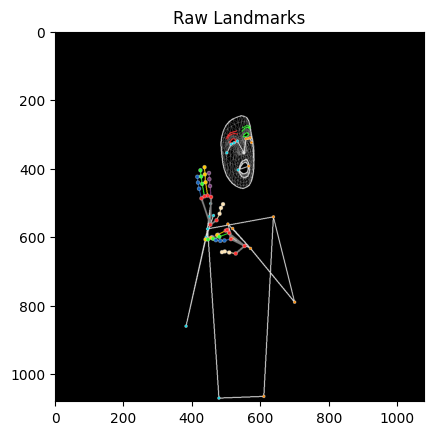

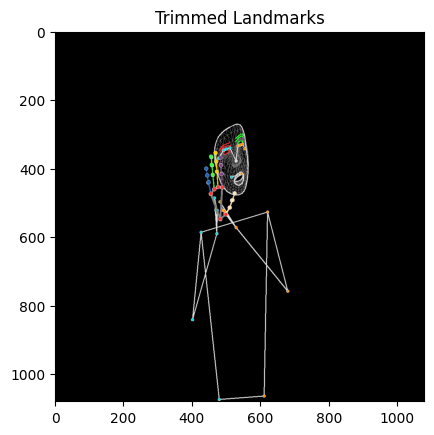

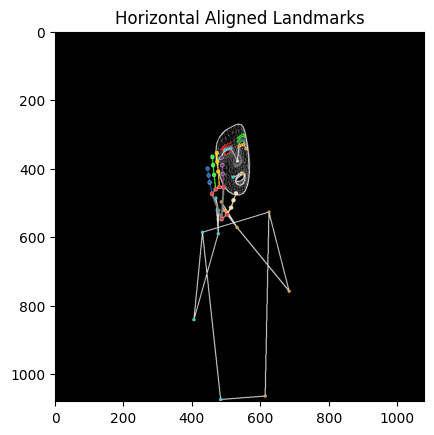

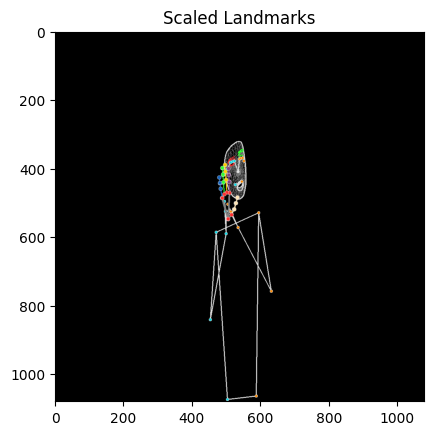

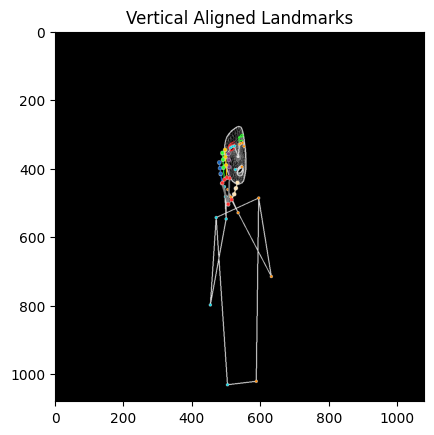

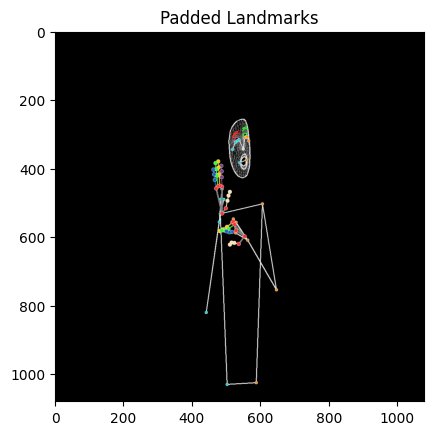

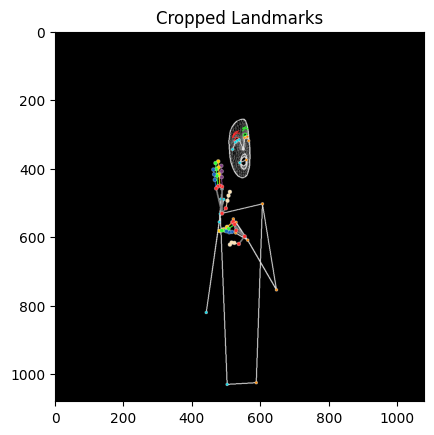

In [26]:
for stage in landmark_stages:
    landmarks = landmark_stages[stage]["landmarks"]
    plot = mph.draw_landmarks_on_frame(np.zeros((1080,1080,3), dtype=np.uint8), landmarks[20])
    plt.imshow(plot[:,:,::-1])
    plt.title(landmark_stages[stage]["description"])
    plt.show()

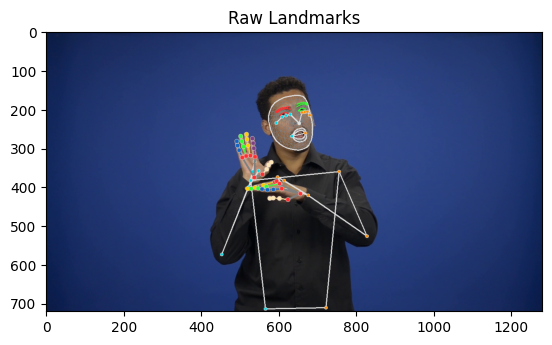

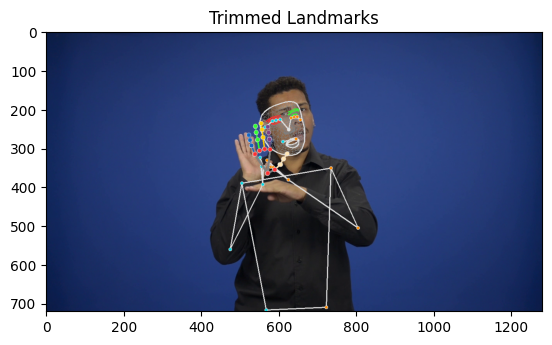

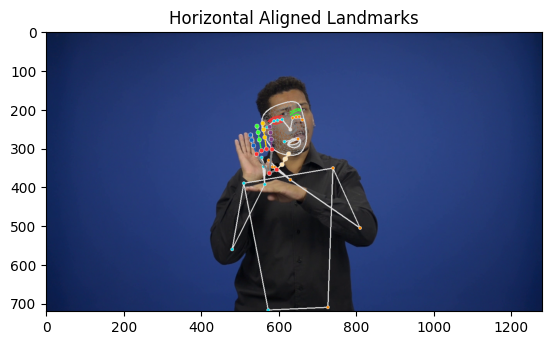

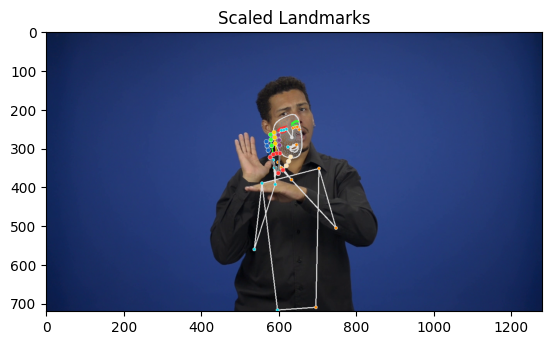

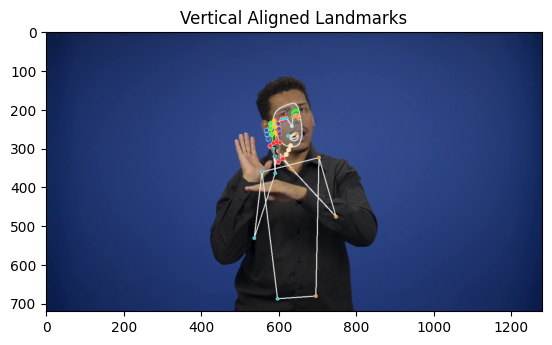

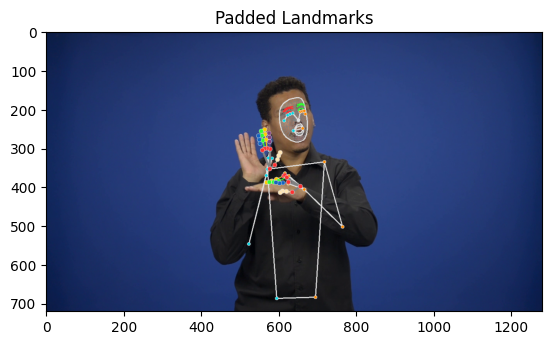

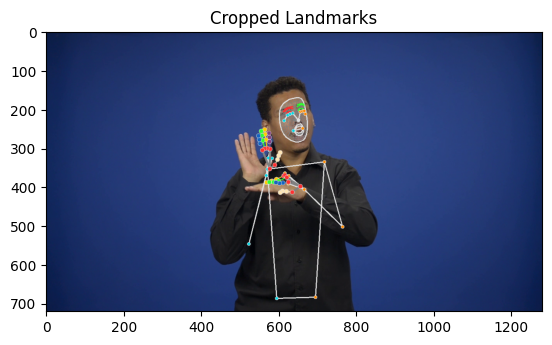

In [27]:
for stage in landmark_stages:
    landmarks = landmark_stages[stage]["landmarks"]
    plot = mph.draw_landmarks_on_frame(frame, landmarks[20], )
    plt.imshow(plot[:,:,::-1])
    plt.title(landmark_stages[stage]["description"])
    plt.show()